In [1]:
import cv2 as cv
import numpy as np
import tarfile
import skimage
import os
from PIL import Image
from skimage import filters
from skimage import morphology
from scipy import ndimage as ndi
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage import exposure
from skimage.exposure import histogram, cumulative_distribution, equalize_hist, match_histograms, is_low_contrast
from skimage import color
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import imutils
from scipy.spatial import distance as dist
from collections import OrderedDict
import copy

In [2]:
import PIL.Image
from others.imAugment import *

## Preprocessing

In [3]:
def plotMultipleImages(nrows, ncols, images, titles, cmap, size=(20,20)):
    fig = plt.figure(figsize=(size[0],size[1]))
    fig.subplots_adjust(hspace=0.2, wspace=0.3)
    for i in range(len(titles)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        if cmap[i]=='rgb':
            ax.imshow(images[i])
        else:
            ax.imshow(images[i], cmap=cmap[i])
        ax.set_title(titles[i])
    plt.show()
    
def plot_single(im, cmap='rgb'):
    fig, ax = plt.subplots(figsize=(13, 13))
    if cmap=='rgb':
        ax.imshow(im)
    else:
        ax.imshow(im, cmap=cmap)
    ax.axis('on')
    plt.show()
    
def enhance_im(rgb_in_im, alpha=1, beta=0):
    #new_im = np.zeros(old_im.shape, old_im.dtype)
    hsv_in_im = cv.cvtColor(rgb_in_im, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_in_im)
    v = cv.convertScaleAbs(v, alpha=alpha, beta=beta)
    hsv_out_im = cv.merge((h,s,v))
    rgb_out_im = cv.cvtColor(hsv_out_im, cv.COLOR_HSV2RGB)
    
    return rgb_out_im.astype(np.uint8)

**1. Load the images into a dictionry (image_ID : image_data)**

We found the image 1 gives the best view, e.g., good brightness and contrast, so we take it as a reference image

In [4]:
def load_img(path):
    img_dict = {}
    for file in os.listdir(path):
        if file.endswith('.jpg'):
            img_dict[int(file.split('.jpg')[0].split('_')[1])] = PIL.Image.open(os.path.join(path, file)) # size = (H=4000, W=6000), mode = RGB
    return img_dict 
train_images = load_img(os.path.join("data", "train"))

# dict_keys([17, 1, 3, 7, 14, 24, 10, 2, 15, 11, 23, 18, 9, 13, 12, 21, 5, 22, 20, 27, 19, 8, 16, 25, 26, 6, 0, 4])
# image 1 gives the best view, we take it as the reference
ref_img = np.array(train_images[0])

In [5]:
table = np.array(PIL.Image.open(os.path.join("data", "image_setup", "table.jpg")))

In [6]:
chip_back_im = table[1000:2800, 2400:3900]

In [7]:
enhance_chip_back_im = enhance_im(chip_back_im, alpha=2.5, beta=3)

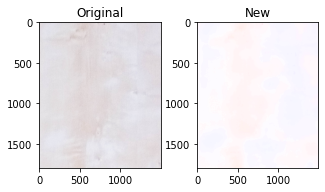

In [8]:
plotMultipleImages(1, 2, [chip_back_im, enhance_chip_back_im], ['Original', 'New'], ['rgb']*2, (5, 5)) 

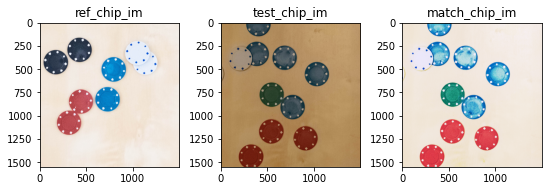

NameError: name 'chip_task' is not defined

In [9]:
ref_img = np.array(train_images[27])
ref_chip_im = ref_img[1250:2800, 2400:3900]
test_img = np.array(train_images[12])
test_chip_im = test_img[1250:2800, 2400:3900]
match_chip_im = match_histograms(test_chip_im, ref_chip_im, multichannel=True).astype(np.uint8)
plotMultipleImages(1, 3, [ref_chip_im, test_chip_im, match_chip_im], ['ref_chip_im', 'test_chip_im', 'match_chip_im'], ['rgb']*3, (9, 9)) 
chip_result = chip_task(match_chip_im)
print(chip_result)

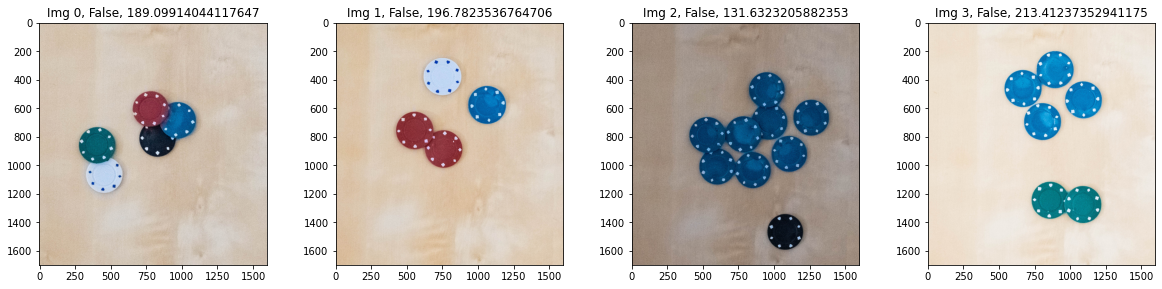

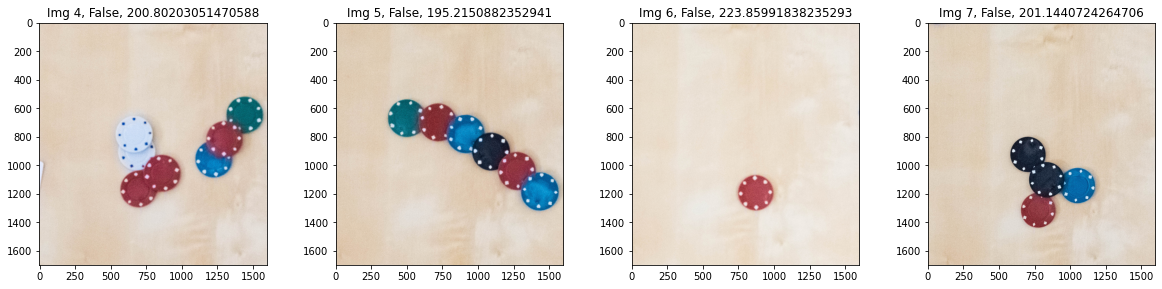

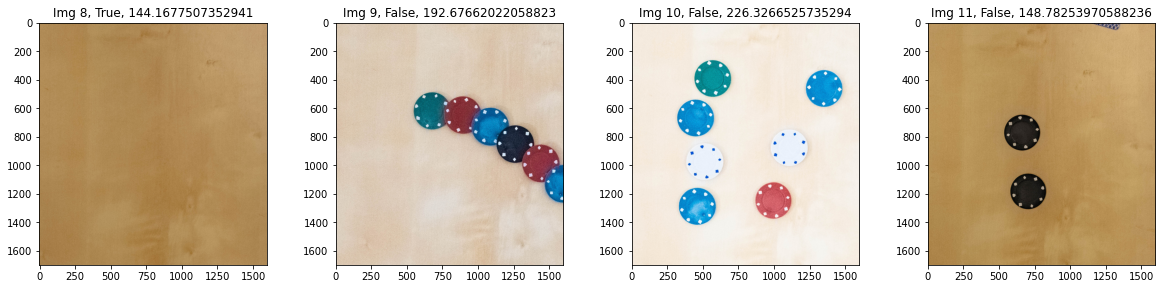

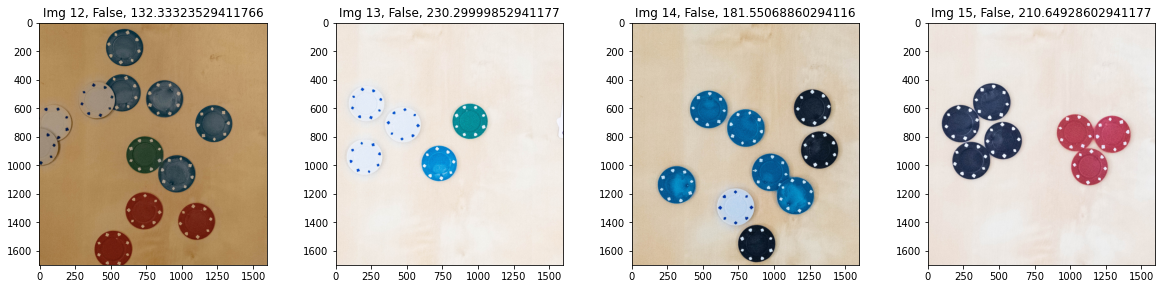

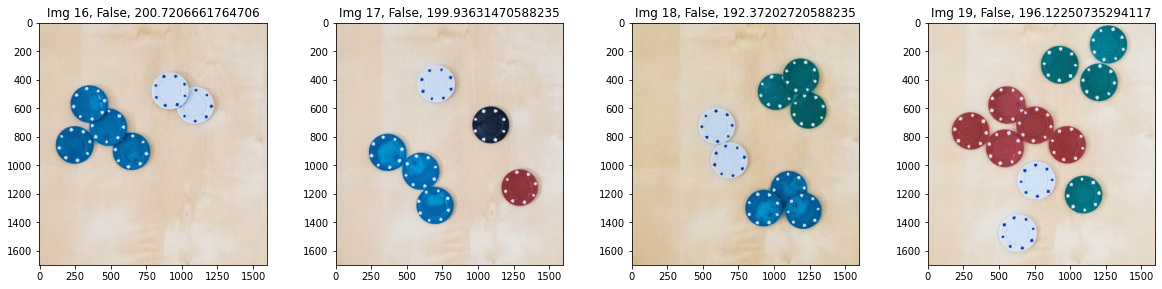

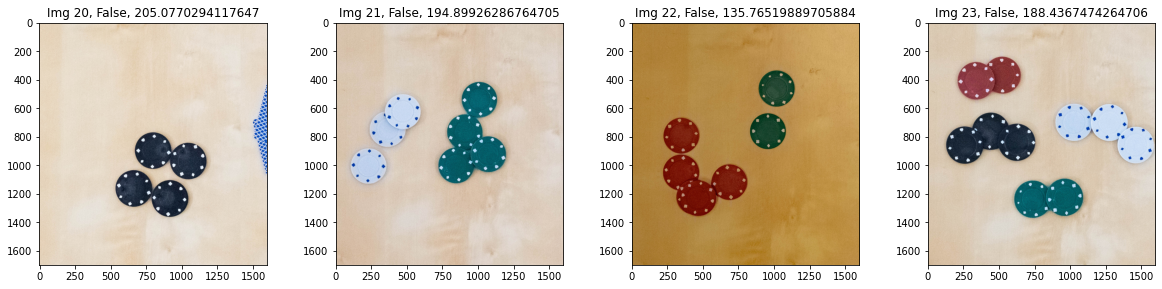

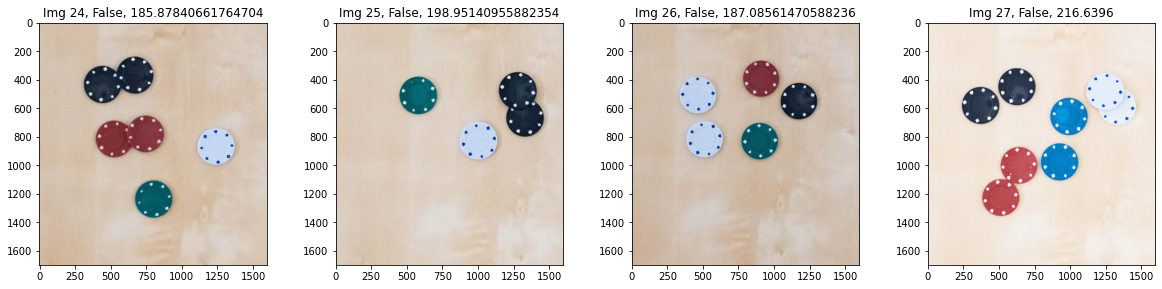

In [10]:
for img_ID in range(0,28,4):
    img_IDs = []
    chip_results = []
    chip_ims = []
    bright = []
    
    for i in range(img_ID, img_ID+4):
        img_IDs.append(i)
        ori_test_img = np.array(train_images[i])
        chip_im = ori_test_img[1100:2800, 2200:3800]
        chip_ims.append(chip_im)
        gray = cv.cvtColor(chip_im, cv.COLOR_RGB2GRAY)   # rgb to gray  
        gray = cv.GaussianBlur(gray,(21,21), 1)
        bright.append(np.mean(gray))
        chip_results.append(is_low_contrast(gray, 0.15))
        
    plotMultipleImages(1, 4, chip_ims, ['Img {}, {}, {}'.format(img_IDs[0], chip_results[0], bright[0]),\
                                       'Img {}, {}, {}'.format(img_IDs[1], chip_results[1], bright[1]),\
                                       'Img {}, {}, {}'.format(img_IDs[2], chip_results[2], bright[2]),\
                                       'Img {}, {}, {}'.format(img_IDs[3], chip_results[3], bright[3])], ['rgb']*4, (20,20))    

In [ ]:
# test image, just provide a ID
img_ID = 12
ori_test_img = np.array(train_images[img_ID])
if img_ID != 0:
    # matching to improve image view
    match_test_img = match_histograms(ori_test_img, ref_img, multichannel=True).astype(np.uint8)

chip_im = match_test_img[1250:2800, 2400:3900]
plotMultipleImages(1, 4, [ori_test_img, match_test_img, chip_im, ref_chip_im], ['Original', 'New', 'Chip', 'ref_chip_im'], ['rgb']*4, (20, 20)) 

In [ ]:
gray_chip_back_im = cv.cvtColor(chip_back_im, cv.COLOR_RGB2GRAY)
gray_output1 = cv.cvtColor(result, cv.COLOR_RGB2GRAY)
gray_chip_im = cv.cvtColor(chip_im, cv.COLOR_RGB2GRAY)

In [ ]:
plotMultipleImages(1, 3, [gray_chip_back_im, gray_output1, gray_chip_im], ['gray_chip_back_im', 'gray_output1', 'chip_im'], ['gray']*3, (15, 15)) 

In [ ]:
chip_fake_im = chip_back_im.copy()
chip_fake_im[np.where(full_mask == 255)] = result[np.where(full_mask == 255)]
plotMultipleImages(1, 3, [chip_back_im, result, chip_fake_im], ['gray_chip_back_im', 'gray_output1', 'chip_fake_im'], ['rgb']*3, (15, 15)) 

In [ ]:
old_chip_identify(chip_fake_im)

In [ ]:
def blue_chip(chip_im):
    output1 = enhance_im(chip_im, alpha=2.5, beta=3)
    result = chip_im.copy()
    #image = cv.cvtColor(chip_im, cv.COLOR_RGB2HSV)
    
    """
    lower1 = np.array([99, 100, 120])
    upper1 = np.array([160, 255, 242])
    lower_mask = cv.inRange(image, lower1, upper1)
    full_mask = lower_mask;
    kernelClose = np.ones((15,15),np.uint8)
    full_mask = cv.morphologyEx(full_mask, cv.MORPH_CLOSE, kernelClose, iterations=2)
    result = cv.bitwise_and(result, result, mask=full_mask)
    """
        
    """
    # lower boundary RED color range values; Hue (0 - 10)
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])
    # upper boundary RED color range values; Hue (160 - 180)
    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])
    lower_mask = cv.inRange(image, lower1, upper1)
    upper_mask = cv.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;
    result = cv.bitwise_and(result, result, mask=full_mask)
    """
    """
    
    lower1 = np.array([34, 0, 0])
    upper1 = np.array([95, 255, 188])
    lower_mask = cv.inRange(image, lower1, upper1)
    full_mask = lower_mask;
    kernelClose = np.ones((15,15),np.uint8)
    full_mask = cv.morphologyEx(full_mask, cv.MORPH_CLOSE, kernelClose, iterations=2)
    result = cv.bitwise_and(result, result, mask=full_mask)
    """
    
    image = cv.cvtColor(chip_im, cv.COLOR_RGB2HLS)
    lower1 = np.array([90, 130, 0])
    upper1 = np.array([115, 255, 255])
    lower_mask = cv.inRange(image, lower1, upper1)
    full_mask = lower_mask;
    result = cv.bitwise_and(result, result, mask=full_mask)
     
    
    chip_fake_im = copy.deepcopy(table[1000:2800, 2200:3900])
    chip_fake_im[np.where(full_mask == 255)] = chip_im[np.where(full_mask == 255)]
    
    chip = 'White'
    if chip != 'White':
        if np.sum(full_mask == 255) > 40000:
        
            binary, sure_fg, dist_transform, contours = old_chip_identify(chip_im, use_full_mask=True, full_mask=full_mask)
        
            plotMultipleImages(1, 6, [chip_im, full_mask, chip_fake_im, binary, dist_transform, sure_fg], \
                           ['ori imag', 'full_mask {}'.format(np.sum(full_mask == 255)), 'chip_fake_im {}'.format(img_ID), 'binary', 'dist_transform', 'sure_fg{}'.format(img_ID)],\
                           ['rgb', 'gray', 'rgb', 'gray', 'gray', 'gray'], (20,20))
        else:
            contours = []
            sure_fg = np.zeros(full_mask.shape, full_mask.dtype)
            plotMultipleImages(1, 3, [chip_im, full_mask, chip_fake_im], \
                           ['ori imag', 'full_mask {}'.format(np.sum(full_mask == 255)), 'chip_fake_im {}'.format(img_ID)],\
                           ['rgb', 'gray', 'rgb'], (10,10))
    else:

        kernelClose = np.ones((3,4),np.uint8)
        opening = cv.morphologyEx(full_mask, cv.MORPH_OPEN, (5,5), iterations=2)
        closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernelClose, iterations=1)

        dist_transform = cv.distanceTransform(closing, cv.DIST_L2, 5)
        ret, sure_fg = cv.threshold(dist_transform, 0.4 * dist_transform.max(), 255, cv.THRESH_BINARY)
        sure_fg = np.uint8(sure_fg)                   

        #plotMultipleImages(1, 3, [chip_im, binary, sure_fg], ['chip_im', 'binary', 'sure_fg', ], ['rgb',  'gray', 'gray'])
        contours, _ = cv.findContours(sure_fg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
        plotMultipleImages(1, 6, [chip_im, full_mask, chip_fake_im, closing, dist_transform, sure_fg], \
                           ['ori imag', 'full_mask {}'.format(np.sum(full_mask == 255)), 'chip_fake_im {}'.format(img_ID), 'closing', 'dist_transform', 'sure_fg{}'.format(img_ID)],\
                           ['rgb', 'gray', 'rgb', 'gray', 'gray', 'gray'], (20,20))
        
    
    count_areas = []
    
    for contour in contours:
        if cv.contourArea(contour) > 3800:
            count_areas.append(cv.contourArea(contour))
    
    return full_mask, result, sure_fg, count_areas

In [ ]:
for img_ID in range(4, 15):
    ori_test_img = np.array(train_images[img_ID])
    chip_im = ori_test_img[1100:2800, 2200:3800]
    

    
    full_mask, result, sure_fg, count_areas = blue_chip(chip_im)
    print("image {} has {} chips and areas = {}".format(img_ID, len(count_areas), count_areas))
    """
    plotMultipleImages(1, 4, [chip_im, full_mask, result, sure_fg], \
                       ['ori imag', 'full_mask {}'.format(img_ID), 'result {}'.format(img_ID), 'sure_fg {}'.format(img_ID)],\
                       ['rgb', 'gray', 'rgb', 'gray'], (20,20)) 
    """
    

In [ ]:
for img_ID in range(15, 29):
    ori_test_img = np.array(train_images[img_ID])
    chip_im = ori_test_img[1100:2800, 2200:3900]
    
    full_mask, result, sure_fg, count_areas = blue_chip(chip_im)
    print("image {} has {} chips and areas = {}".format(img_ID, len(count_areas), count_areas))
    """
    plotMultipleImages(1, 4, [chip_im, full_mask, result, sure_fg], \
                       ['ori imag', 'full_mask {}'.format(img_ID), 'result {}'.format(img_ID), 'sure_fg {}'.format(img_ID)],\
                       ['rgb', 'gray', 'rgb', 'gray'], (20,20)) 
    """
    

Blue: image_12 with brightness and contrast issue

Red: all pass

green: all pass

white: image_12 with brightness and contrast issue

black: total - blue - red - green

In [ ]:
def HSV_range(chip_type):
    if chip_type == "CR":
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
    elif chip_type == "CG":
        lower1 = np.array([34, 0, 0])
        upper1 = np.array([95, 255, 188])
        
    elif chip_type == "CB":
        lower1 = np.array([99, 100, 120])
        upper1 = np.array([160, 255, 242])
        
    elif chip_type == "CW":
        lower1 = np.array([90, 130, 0])
        upper1 = np.array([115, 255, 255])
       
    return lower1, upper1

def RGB_chip_identify(chip_im, use_full_mask=False, full_mask=None):
    """
    function to identify position of chips
    """
    h, w, ch = chip_im.shape
    gray = cv.cvtColor(chip_im, cv.COLOR_RGB2GRAY)   # rgb to gray  
    gray = cv.GaussianBlur(gray,(21,21), 1)
    ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV  + cv.THRESH_OTSU) # Otsu's thresholding after Gaussian filtering

    if use_full_mask != False:
        chip_fake_binary = np.zeros(binary.shape, binary.dtype)
        chip_fake_binary[np.where(full_mask == 255)] = binary[np.where(full_mask == 255)]
    else:
        #print("false")
        chip_fake_binary = binary

    
    kernelClose = np.ones((11,11),np.uint8)
    opening = cv.morphologyEx(chip_fake_binary, cv.MORPH_OPEN, (5,5), iterations=2)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernelClose, iterations=1)

    dist_transform = cv.distanceTransform(closing, cv.DIST_L2, 5)
    ret, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)      
    
    
    #plotMultipleImages(1, 3, [chip_im, binary, sure_fg], ['chip_im', 'binary {}'.format(np.sum(chip_fake_binary == 255)), 'sure_fg', ], ['rgb',  'gray', 'gray'], (15,15))
    contours, _ = cv.findContours(sure_fg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return chip_fake_binary, sure_fg, dist_transform, contours
        

def chip_task(chip_im):
    # Chips
    chip_results = {"CR": 0, "CG": 0, "CB": 0, "CK": 0, "CW": 0}
    
    gray = cv.cvtColor(chip_im, cv.COLOR_RGB2GRAY)   # rgb to gray  
    gray = cv.GaussianBlur(gray,(21,21), 1)
    ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV  + cv.THRESH_OTSU) # Otsu's thresholding after Gaussian filtering

    # In case of no chips
    if np.sum(binary == 255) > 1e6:
        return chip_results
    
    # first process RGB chips
    for chip_type in ["CR", "CG", "CB"]:
        image = cv.cvtColor(chip_im, cv.COLOR_RGB2HSV)
        lower1, upper1 = HSV_range(chip_type)
        lower_mask = cv.inRange(image, lower1, upper1)

        if chip_type == "CR":
            lower2 = lower1 + np.array([160, 0, 0])
            upper2 = upper1 + np.array([170, 0, 0])
            upper_mask = cv.inRange(image, lower2, upper2)
            full_mask = lower_mask + upper_mask;
            
        else:  
            full_mask = lower_mask;
            
        # give fake images
        chip_fake_im = copy.deepcopy(table[1000:2800, 2200:3900])
        chip_fake_im[np.where(full_mask == 255)] = chip_im[np.where(full_mask == 255)]
            
        # give better masks
        kernelClose = np.ones((15,15), np.uint8)
        full_mask = cv.morphologyEx(full_mask, cv.MORPH_CLOSE, kernelClose, iterations=2)
        
        # if with coins
        if np.sum(full_mask == 255)>40000:
            chip_fake_binary, sure_fg, dist_transform, contours = RGB_chip_identify(chip_im, use_full_mask=True, full_mask=full_mask)
            
            plotMultipleImages(1, 6, [chip_im, full_mask, chip_fake_im, binary, dist_transform, sure_fg], \
                           ['ori imag', 'full_mask {}'.format(np.sum(full_mask == 255)), 'chip_fake_im {}'.format(img_ID), 'binary', 'dist_transform', 'sure_fg{}'.format(img_ID)],\
                           ['rgb', 'gray', 'rgb', 'gray', 'gray', 'gray'], (20,20))
            
        else:
            # if no chips
            contours = []
            
            plotMultipleImages(1, 3, [chip_im, full_mask, chip_fake_im], \
                           ['ori imag', 'full_mask {}'.format(np.sum(full_mask == 255)), 'chip_fake_im {}'.format(img_ID)],\
                           ['rgb', 'gray', 'rgb'], (10,10))
            
        
        #count_areas = []
        for contour in contours:
            if cv.contourArea(contour) > 3800:
                #count_areas.append(cv.contourArea(contour))
                chip_results[chip_type] += 1
                
    for chip_type in ["CK"]:
        chip_fake_binary, sure_fg, dist_transform, contours = RGB_chip_identify(chip_im, use_full_mask=False)
        
        plotMultipleImages(1, 4, [chip_im, chip_fake_binary, sure_fg, dist_transform], \
                       ['ori imag', 'chip_fake_binary {}'.format(img_ID), 'sure_fg {}'.format(img_ID), 'dist_transform {}'.format(img_ID)],\
                       ['rgb', 'gray', 'gray', 'gray'], (20,20)) 
        
        total_chip = 0
        for contour in contours:
            if cv.contourArea(contour) > 3800:
                #count_areas.append(cv.contourArea(contour))
                total_chip += 1
                
        #print(chip_type, total_chip)
        chip_results[chip_type] = total_chip - chip_results["CR"] - chip_results["CG"]- chip_results["CB"]
        

    for chip_type in ["CW"]:
        image = cv.cvtColor(chip_im, cv.COLOR_RGB2HLS)
        lower1, upper1 = HSV_range(chip_type)
        lower_mask = cv.inRange(image, lower1, upper1)
        full_mask = lower_mask
        
        # give fake images
        chip_fake_im = copy.deepcopy(table[1000:2800, 2200:3900])
        chip_fake_im[np.where(full_mask == 255)] = chip_im[np.where(full_mask == 255)]

        kernelClose = np.ones((3,4),np.uint8)
        opening = cv.morphologyEx(full_mask, cv.MORPH_OPEN, (5,5), iterations=2)
        closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernelClose, iterations=1)

        dist_transform = cv.distanceTransform(closing, cv.DIST_L2, 5)
        ret, sure_fg = cv.threshold(dist_transform, 0.4 * dist_transform.max(), 255, cv.THRESH_BINARY)
        sure_fg = np.uint8(sure_fg)                   

        contours, _ = cv.findContours(sure_fg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
        """
        plotMultipleImages(1, 6, [chip_im, full_mask, chip_fake_im, closing, dist_transform, sure_fg], \
                           ['ori imag', 'full_mask {}'.format(np.sum(full_mask == 255)), 'chip_fake_im {}'.format(img_ID), 'closing', 'dist_transform', 'sure_fg{}'.format(img_ID)],\
                           ['rgb', 'gray', 'rgb', 'gray', 'gray', 'gray'], (20,20))
        """
        for contour in contours:
            if cv.contourArea(contour) > 3800:
                chip_results[chip_type] += 1
        
    
    return chip_results
    
    
    


In [ ]:
for img_ID in range(0,28,4):
    img_IDs = []
    chip_results = []
    chip_ims = []
    
    for i in range(img_ID, img_ID+4):
        img_IDs.append(i)
        ori_test_img = np.array(train_images[i])
        chip_im = ori_test_img[1100:2800, 2200:3800]
        chip_ims.append(chip_im)
        chip_result = chip_task(chip_im)
        chip_results.append(chip_result)
        
    plotMultipleImages(1, 4, chip_ims, ['Img {}, {}'.format(img_IDs[0], chip_results[0]),\
                                       'Img {}, {}'.format(img_IDs[1], chip_results[1]),\
                                       'Img {}, {}'.format(img_IDs[2], chip_results[2]),\
                                       'Img {}, {}'.format(img_IDs[3], chip_results[3])], ['rgb']*4, (20,20))
    

In [ ]:
gray_chip_im[full_mask] = gray_output1[full_mask]
plotMultipleImages(1, 3, [gray_chip_back_im, gray_output1, gray_chip_im], ['gray_chip_back_im', 'gray_output1', 'chip_im'], ['gray']*3, (15, 15)) 

In [ ]:
full_mask.shape

In [ ]:
dst = cv.bitwise_and(chip_back_im,  result, mask=full_mask)
plot_single(dst)

In [ ]:
chip_back_im.shape

In [ ]:
result.shape

In [ ]:
plot_single(chip_back_im)

In [ ]:
dst = cv.addWeighted(chip_back_im,0.7,result,0.5,0)

plot_single(dst)

In [ ]:
result = chip_im.copy()
 
image = cv.cvtColor(chip_im, cv.COLOR_RGB2HSV)
 
# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([100, 80, 80])
upper1 = np.array([124, 255, 255])

lower_mask = cv.inRange(image, lower1, upper1)
full_mask = lower_mask;
result = cv.bitwise_and(result, result, mask=full_mask)
plotMultipleImages(1, 3, [chip_im, full_mask, result], ['ori', 'full_mask', 'result'], ['rgb','gray', 'rgb'], (20,20)) 
sure_fg, contours = chip_identify(full_mask)
print(len(contours))
plotMultipleImages(1, 3, [full_mask, result, sure_fg], ['full_mask', 'result', 'sure_fg'], ['gray', 'hsv', 'gray'], (20,20)) 

In [ ]:
img_ID = 5
ori_test_img = np.array(train_images[img_ID])
chip_im = ori_test_img[1250:2800, 2400:3900]

#full_mask, result, sure_fg, num_red = red_chip(chip_im)
full_mask, result, sure_fg, num_red = blue_chip(chip_im)
print("image {} has {} chips".format(img_ID, num_red))
plotMultipleImages(1, 4, [chip_im, full_mask, result, sure_fg], \
                   ['ori imag', 'full_mask {}'.format(img_ID), 'result {}'.format(img_ID), 'sure_fg {}'.format(img_ID)],\
                   ['rgb', 'gray', 'rgb', 'gray'], (20,20)) 

In [ ]:
def red_chip(chip_im):
    result = chip_im.copy()
    image = cv.cvtColor(chip_im, cv.COLOR_RGB2HSV)
    
    # lower boundary RED color range values; Hue (0 - 10)
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])
    # upper boundary RED color range values; Hue (160 - 180)
    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])
    
    lower_mask = cv.inRange(image, lower1, upper1)
    upper_mask = cv.inRange(image, lower2, upper2)
    
    full_mask = lower_mask + upper_mask;
    
    result = cv.bitwise_and(result, result, mask=full_mask)
    plotMultipleImages(1, 4, [chip_im, full_mask, result], \
                       ['ori imag', 'full_mask {}'.format(img_ID), 'result {}'.format(img_ID)],\
                       ['rgb', 'gray', 'rgb'], (20,20)) 
    
    sure_fg, contours = chip_identify(result)
    
    count_areas = []
    
    for contour in contours:
        count_areas.append(cv.contourArea(contour))
    
    return full_mask, result, sure_fg, len(contours), count_areas

In [ ]:
def chip_identify(chip_im):
    """
    function to identify position of chips
    """

    h, w, ch = chip_im.shape
    gray = cv.cvtColor(chip_im, cv.COLOR_RGB2GRAY)   # rgb to gray  
    gray = cv.GaussianBlur(gray,(21,21), 1)
    ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_OTSU) # Otsu's thresholding after Gaussian filtering
    """
    opening = cv.morphologyEx(binary, cv.MORPH_OPEN, (21,21), iterations=2)
    kernelErode = np.ones((3,3),np.uint8)
    erosion = cv.erode(opening,kernelErode,iterations = 1)
    kernelClose = np.ones((11,11),np.uint8)
    closing = cv.morphologyEx(erosion, cv.MORPH_CLOSE, kernelClose, iterations=2)

    kernelDilate = np.ones((13,13),np.uint8)
    sure_bg  = cv.dilate(closing, kernelDilate, iterations = 2)
    """
    
    opening = cv.morphologyEx(binary, cv.MORPH_OPEN, (13,13), iterations=2)
    
    kernelClose = np.ones((13,13),np.uint8)
    closing = cv.morphologyEx(binary, cv.MORPH_CLOSE, kernelClose, iterations = 2)
    #kernelErode = np.ones((11,11),np.uint8)
    #erosion = cv.erode(closing,kernelErode,iterations = 1)
    
    #
    

    kernelDilate = np.ones((15,15),np.uint8)
    sure_bg  = cv.dilate(closing, kernelDilate, iterations = 2)
    

    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)

    ret, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, cv.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv.subtract(sure_bg, sure_fg)

    ret, markers = cv.connectedComponents(sure_fg) 
    markers = markers+1                             
    markers[unknown == 255] = 0                     
    
    plotMultipleImages(1, 5, [binary, closing, sure_bg, dist_transform, sure_fg], ['binary', 'opening', 'sure_bg', 'dist_transform', 'sure_fg'], ['gray']*5, (15,15))
    contours, _ = cv.findContours(sure_fg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return sure_fg, contours

In [ ]:
def green_chip(chip_im):
    #output1 = enhance_im(chip_im, alpha=1.5, beta=3)
    result = chip_im.copy()
    image = cv.cvtColor(chip_im, cv.COLOR_RGB2HSV)
    
     # lower boundary GREEN color range values; Hue (0 - 10)
    lower1 = np.array([34, 0, 0])
    upper1 = np.array([98, 255, 188])
    lower_mask = cv.inRange(image, lower1, upper1)
    full_mask = lower_mask;
    result = cv.bitwise_and(result, result, mask=full_mask)
    
    plotMultipleImages(1, 4, [chip_im, full_mask, result], \
                       ['ori imag', 'full_mask {}'.format(img_ID), 'result {}'.format(img_ID)],\
                       ['rgb', 'gray', 'rgb'], (20,20)) 
    
    sure_fg, contours = chip_identify(result)
    count_areas = []
    
    for contour in contours:
        count_areas.append(cv.contourArea(contour))
    
    return full_mask, result, sure_fg, len(contours), count_areas

In [ ]:
for img_ID in range(15, 29):
    ori_test_img = np.array(train_images[img_ID])
    chip_im = ori_test_img[1100:2800, 2400:3900]
    

    
    #full_mask, result, sure_fg, num_red = red_chip(chip_im)
    full_mask, result, sure_fg, num_chip, count_areas = blue_chip(chip_im)
    print("image {} has {} chips and areas = {}".format(img_ID, num_chip, count_areas))
    """
    plotMultipleImages(1, 4, [chip_im, full_mask, result, sure_fg], \
                       ['ori imag', 'full_mask {}'.format(img_ID), 'result {}'.format(img_ID), 'sure_fg {}'.format(img_ID)],\
                       ['rgb', 'gray', 'rgb', 'gray'], (20,20)) 
    """
    

In [ ]:
full_mask.shape

In [ ]:
from skimage.color import rgb2gray
def find_chips(chip_im, r_min=20, r_max=100):
    all_chips  = chip_im.copy()
    gray = cv.cvtColor(chip_im, cv.COLOR_RGB2GRAY)   # rgb to gray
    gray = cv.medianBlur(gray, 5)
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, r_min, param1=80, param2=40, minRadius=r_min, maxRadius=r_max)
    
    masks = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            one_chip = chip_im.copy()
            center = (i[0], i[1])
            radius = i[2]
            cv.circle(all_chips, center, radius, (0, 0, 0), thickness=-1)
            cv.circle(one_chip, center, radius, (0, 0, 0), thickness=-1)
            gray_chip = rgb2gray(one_chip)
            mask = (gray_chip < 0.0001).astype(int)
            masks.append(mask)

    gray2 = rgb2gray(all_chips)
    big_mask = (gray2 < 0.0001)
    
    return big_mask, masks


In [ ]:
for img_ID in range(28):
    ori_test_img = np.array(train_images[img_ID])
    chip_im = ori_test_img[1250:2800, 2400:3900]
    
    big_mask, masks = find_chips(chip_im, r_min=50, r_max=130)
    chips2 = chip_im.copy()
    chips2[big_mask==0] = 0

    plt.imshow(chips2, cmap='gray')
    plt.show()

In [ ]:
chip_mark  = chip_task(copy.deepcopy(chip_im))
plotMultipleImages(1, 1, [chip_mark], ['chip with label'], ['rgb'], (8, 8))  

In [ ]:
1e6

In [ ]:
def old_chip_identify(chip_im, use_full_mask=False, full_mask=None):
    """
    function to identify position of chips
    """
    h, w, ch = chip_im.shape
    gray = cv.cvtColor(chip_im, cv.COLOR_RGB2GRAY)   # rgb to gray  
    gray = cv.GaussianBlur(gray,(21,21), 1)
    ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV  + cv.THRESH_OTSU) # Otsu's thresholding after Gaussian filtering

    if full_mask != False:
        chip_fake_binary = np.zeros(binary.shape, binary.dtype)
        chip_fake_binary[np.where(full_mask == 255)] = binary[np.where(full_mask == 255)]
    else:
        chip_fake_binary = binary

    
    kernelClose = np.ones((11,11),np.uint8)
    opening = cv.morphologyEx(chip_fake_binary, cv.MORPH_OPEN, (5,5), iterations=2)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernelClose, iterations=1)
    
    

    dist_transform = cv.distanceTransform(closing, cv.DIST_L2, 5)
    ret, sure_fg = cv.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)      
    
    if np.sum(chip_fake_binary == 255)>1e6:
        print("Empty table")
    
    plotMultipleImages(1, 3, [chip_im, binary, sure_fg], ['chip_im', 'binary {}'.format(np.sum(chip_fake_binary == 255)), 'sure_fg', ], ['rgb',  'gray', 'gray'], (15,15))
    contours, _ = cv.findContours(sure_fg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return chip_fake_binary, sure_fg, dist_transform, contours

In [ ]:
for img_ID in range(1, 28):
    ori_test_img = np.array(train_images[img_ID])
    chip_im = ori_test_img[1100:2800, 2400:3900]
    chip_mark  = old_chip_identify(copy.deepcopy(chip_im), use_full_mask=False)